# preparations

## loading necessary libraries

In [ ]:
%pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 18.9 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, execute
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector, DensityMatrix

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

## noise model based on IonQ's Aria specifications:
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for $t$

In [31]:
# error probabilities
p_meas = 0.39/100
p_reset = 0.39/100
p_gate1 = 0.06/100
p_gate2 = 0.6/100

# thermal relaxation error (nanosecond time)
T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = np.random.choice(range(600, 700), 10, replace=False)
time_u1 = 0 # virtual gate
time_gate1 = 135e3 # u1 and u2
time_gate2 = 600e3 # 2 qubit gate

# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

# creating the noise model
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

## miscellaneous

In [32]:
#graph plotter
def createGraph(GraphLaplacian: list[list[int]]):
    Edges = []
    for i, row in enumerate(GraphLaplacian):
        for j, v in enumerate(row[:i]):
            if v == - 1:
                Edges.append([i, j])
    Graph = nx.Graph()
    Graph.add_edges_from(Edges)
    nx.draw_networkx(Graph)

### Grover parameter finder: this optimizes `delta` $\in (0, 1)$ so that the query complexity is minimal for a given pair of target probability and ratio, `P` and `Lambda`

In [33]:
def Chebyshev(x: float, L:  float):
    return np.cos(L * np.arccos(x)) if x <= 1 else np.cosh(L * np.arccosh(x))

def GroverParameterOptimizer(P: float, Lambda: float, N: int):
    step, L_bound, p = pow(2, - N), 1, 0
    while p < P:
        delta = step
        l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        while l > L_bound:
            delta += step
            l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        while delta < 1 and p < P:
            p = 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)
            if p < P:
                delta += step
                l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        if delta == 1:
            L_bound += 1

    return delta, l, p

# circuits

### Quantum Fourier Transform

In [34]:
def QuantumFourierTransform(digits: int):
    
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegY)

    for i, q in enumerate(QRegY):
        QC.h(q)
        theta = np.pi / 2
        for r in QRegY[i + 1:]:
            QC.cp(theta, r, q)
            theta /= 2
    
    return QC.to_gate()

### cost/energy oracle: $U_C | x \rangle | 0 \rangle = | x \rangle \left( \widehat{\mathrm{QFT}}| y - 1 - C (x) \rangle \right)$

In [35]:
def EnergyOracle(QuadraticForm: list[list[int]], y: int, digits: int):

    QRegX = QuantumRegister(len(QuadraticForm))
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegY)

    t = np.trace(QuadraticForm)
    s = QuadraticForm.sum()

    # adding y-1-sum(Q)-trace/4 to the anicillas
    theta = np.pi * (y-1-s-t/4)
    for q in reversed(QRegY):
        QC.rz(theta, q)
        theta /= 2
    
    # subtracting (C(x)+sum(Q)+trace/4) from the anicillas
    for i, p in enumerate(QRegX[:-1]):

        if np.sum(QuadraticForm[i]) != 0:
            # double-check this for loop for general QUBOs
            theta = - np.sum(QuadraticForm[i]) * np.pi
            for q in reversed(QRegY):
                QC.cx(q, r)
                QC.rz(- theta, p)
                QC.cx(q, r)
                QC.rz(theta, p)
                theta /= 2

        for j, r in enumerate(QRegX[i + 1:]):
            if QuadraticForm[i][i + 1 + j] != 0:
                QC.cx(p, r)
                theta = QuadraticForm[i][i + 1 + j] * np.pi / 2
                # QRegY is reversed below to save on swaps in QFT
                for q in reversed(QRegY):
                    QC.cx(q, r)
                    QC.rz(- theta, r)
                    QC.cx(q, r)
                    QC.rz(theta, r)
                    theta /= 2
                QC.cx(p, r)

    return QC.to_gate()

### Grover Fixed Point Search for graph cuts

In [48]:
def GroverForMaxCut(QuadraticForm: list[list[int]], digits: int, y: int, delta: float, Lambda: float, noise: bool):

    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
    gamma = 1 / np.sqrt(1 - pow(np.cosh(np.arccosh(1 / delta) / (2 * l + 1)), - 2))
    angles = [2 * np.arctan(gamma / np.tan(2 * np.pi * j / (2 * l + 1))) for j in range(1, l + 1)]

    QFT = QuantumFourierTransform(digits)
    IQFT = QFT.inverse()

    # one quantum register for each vertex
    QRegX = QuantumRegister(len(QuadraticForm), "x")

    # quantum registers to digitize y
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)
    
    CostGate = EnergyOracle(QuadraticForm, y, digits)
    CostGate.label = "Cost Gate"
    CostGateInverse = CostGate.inverse()
    CostGateInverse.label = "Cost Gate Inverse"

    QC.h(QRegX)

    for alpha, beta in zip(angles, reversed(angles)):

        # S_t (beta)
        QC.append(CostGate, QRegX[:] + QRegY[:])

        # these next three lines ought to be simplifiable
        QC.append(IQFT, QRegY)
        QC.p(beta, QRegY[0])
        QC.append(QFT, QRegY)

        QC.append(CostGateInverse, QRegX[:] + QRegY[:])
        
        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        QC.mcp(alpha, QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.h(QRegX)

    if noise:
        QC.save_density_matrix(qubits=QRegX, label=f"rho", pershot=True, conditional=True)
        simulator = AerSimulator(method="density_matrix", noise_model=fake_aria)
        psi = execute(QC, simulator, shots=20).result().data()["rho"][""][0].probabilities()
    else:
        '''
        QC.save_density_matrix(qubits=QRegX, label=f"rho")
        simulator = AerSimulator(method="density_matrix")
        rho = execute(QC, simulator).result().data()["rho"]
        psi = rho.probabilities()
        '''
        QC.save_statevector()
        simulator = AerSimulator(method="statevector")
        psi = Statevector(execute(QC, simulator).result().get_statevector()).probabilities(np.arange(len(QRegX)))
    
    return psi

# parameters & testing:

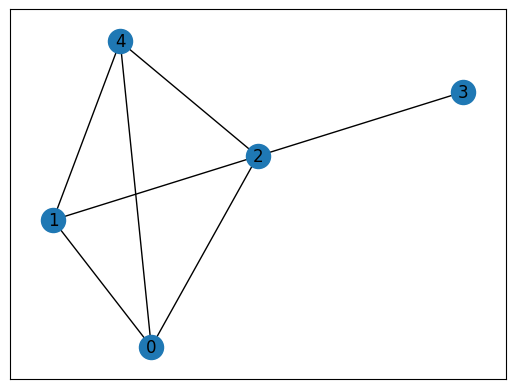

In [49]:
# graph size
NumberOfVerticies = 5 # must be <= 18 to fit in Aria
edge_probability = 0.5

# random, connected graph
disconnected = True
while disconnected:
    GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
    for i in range(NumberOfVerticies):
        for j in range(i + 1, NumberOfVerticies):
            if np.random.rand() < edge_probability:
                GraphLaplacian[i][j] = GraphLaplacian[j][i] = - 1
        GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])
    disconnected = (NumberOfVerticies != np.linalg.matrix_rank(GraphLaplacian) + 1)

NumberOfEdges = np.trace(GraphLaplacian) >> 1

# Erdos-Edwards bound for connected graphs
y = (2 * NumberOfEdges + NumberOfVerticies - 1) >> 2

digits = 1 + int(np.ceil(np.log2(max(y, NumberOfEdges + 1 - y)))) if NumberOfVerticies > 2 else 2

createGraph(GraphLaplacian)



# classical maxcut computation:
maxdeg = [0, 0]
for i in range(NumberOfVerticies):
    if GraphLaplacian[i][i] > maxdeg[1]:
        maxdeg = [i, GraphLaplacian[i][i]]

if maxdeg[0] + 1 != NumberOfVerticies:
    GraphLaplacian[[maxdeg[0], -1], :] = GraphLaplacian[[-1, maxdeg[0]], :]
    GraphLaplacian[:, [maxdeg[0], -1]] = GraphLaplacian[:, [-1, maxdeg[0]]]

Q = GraphLaplacian[np.ix_(np.arange(NumberOfVerticies - 1),np.arange(NumberOfVerticies - 1))]

MaxCut, Lambda = y, 0
for x in range(1 << (NumberOfVerticies - 1)):
    conf = np.array([(x >> i)&1 for i in range(NumberOfVerticies - 1)])
    cut = np.matmul(conf, np.matmul(Q, np.transpose(conf)))
    if cut >= y:
        Lambda += pow(2, 1 - NumberOfVerticies)
        if cut > MaxCut:
            MaxCut = cut

In [50]:
# Grover target probability
P_L = 0.95
delta, l, prob = GroverParameterOptimizer(P_L, Lambda, 10)
print(f"MaxCut\ty\tLambda\tdigits\tdelta\tl\tprob\n{MaxCut}\t{y}\t{round(Lambda, 2)}\t{digits}\t{round(delta, 2)}\t{l}\t{round(prob, 2) * 100}%")

MaxCut	y	Lambda	digits	delta	l	prob
5	4	0.62	3	0.08	1	99.0%


### simulation:

In [51]:
noise = True # don't run it with more than 6 vertices
#noise = False

print(f"\ncomputation with Grover Fixed Point Search...\n")
start_time = time.time()
psi = GroverForMaxCut(GraphLaplacian, digits, y, delta, Lambda, noise)
end_time = time.time()
print(f"done in {round(end_time - start_time, 2)} seconds\n")


computation with Grover Fixed Point Search...

done in 1.64 seconds



In [52]:
s = "simulation with noise\n" if noise else "simulation without noise\n"
s += f"\nthe graph:\n----------\nMaxCut\t\t\t= {MaxCut}\nnumber of edges\t\t= {np.trace(GraphLaplacian) >> 1}\nErdos-Edwards bound\t= {y}\n\n"
for row in GraphLaplacian:
    s += f"{row.view()}\n"
s += "\n"
s += f"Grover parameters:\n------------------\nLambda\t= {round(Lambda, 3)}\ndelta\t= {round(delta, 2)}\nl\t= {l}\n\n"
s += f"results with Grover:\n--------------------\n\n"

M = var = success = 0
distribution = {}
random_chance = {}
for i in range(MaxCut + 1):
    distribution[i] = random_chance[i] = 0

for i, p in enumerate(psi):
    conf = [(i >> j)&1 for j in range(NumberOfVerticies)]
    cut = np.matmul(conf, np.matmul(GraphLaplacian, np.transpose(conf)))
    distribution[cut] += p
    random_chance[cut] += pow(2, - NumberOfVerticies)
    M += p * cut
    var += p * cut * cut
    if cut >= y:
        success += p
var -= M*M

m, sigma = 0, 0
difference = {}
for cut in range(MaxCut + 1):
    difference[cut] = distribution[cut] - random_chance[cut]
    m += cut * random_chance[cut]
    sigma += cut * cut * random_chance[cut]

sigma -= m*m
sign_m = "+" if M >= m else "-"
sign_sigma = "+" if var >= sigma else "-"
    
s += f"expectation\t= {round(M, 2)}\t({m} {sign_m} {round(abs(M - m), 2)})\nvariance\t= {round(np.sqrt(var), 2)}\t({round(np.sqrt(sigma), 1)} {sign_sigma} {round(abs(np.sqrt(var) - np.sqrt(sigma)), 2)})\n\n"
s += f"success probability = {round(success * 100, 2)}% (theoretical value = {round(prob, 2) * 100}%)\n"

print(s)

simulation with noise

the graph:
----------
MaxCut			= 5
number of edges		= 7
Erdos-Edwards bound	= 4

[ 3 -1 -1  0 -1]
[-1  3 -1  0 -1]
[-1 -1  3  0 -1]
[ 0  0  0  1 -1]
[-1 -1 -1 -1  4]

Grover parameters:
------------------
Lambda	= 0.625
delta	= 0.08
l	= 1

results with Grover:
--------------------

expectation	= 3.8	(3.5 + 0.3)
variance	= 1.15	(1.3 - 0.17)

success probability = 76.68% (theoretical value = 99.0%)



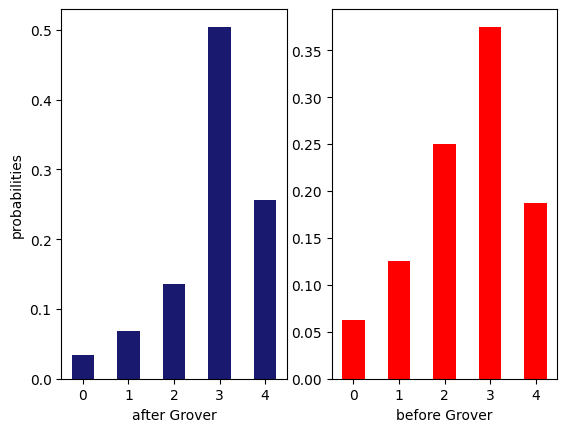

In [47]:
fig, axs = plt.subplots(1, 2)

axs[0].bar(distribution.keys(),
              distribution.values(),
              width=0.5,
              color="midnightblue",
              tick_label=[i for i in range(MaxCut + 1)])
axs[0].set(xlabel=f"after Grover", ylabel=f"probabilities")

axs[1].bar(distribution.keys(),
              random_chance.values(),
              width=0.5,
              color="red",
              tick_label=[i for i in range(MaxCut + 1)])
axs[1].set(xlabel=f"before Grover")

plt.show()

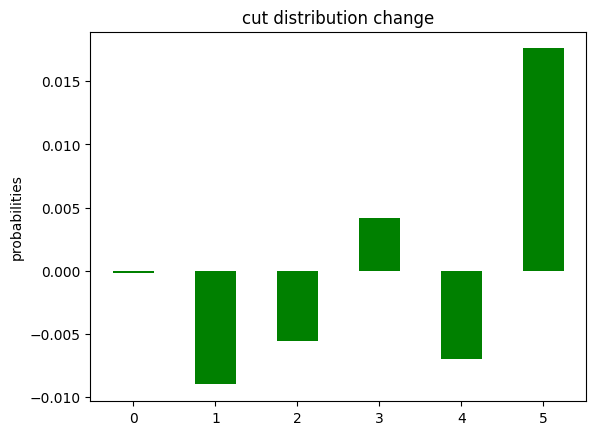

In [ ]:
plt.bar(difference.keys(),
        difference.values(),
        width=0.5,
        color="green",
        tick_label=[i for i in range(MaxCut + 1)])
plt.title(f"cut distribution change")
plt.ylabel(f"probabilities")
plt.show()